In [3]:
import warnings
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional
import matplotlib.ticker as ticker

# custom
import torch
import os
import glob
from collections import defaultdict


def tree():
    return defaultdict(tree)


import sys

sys.path.append(os.path.abspath("../../"))  # Adjust if needed to make `src` importable
from src.utils.plots_utils import hist_weights_plot, hist_line, compute_hist_data, Line


TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLOR_orange = "darkorange"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "GNN": NN_COLOR_orange,
}
rect = (0.135, 0.18, 0.96, 0.96)
rect_both_axes = (0.14, 0.17, 0.845, 0.96)
figsize = (6, 4.5)

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

linewidth = 2.0


@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    linewidth: Optional[float] = 1.0
    fill: bool = False
    vline: bool = False
    alpha: float = 1.0
    linewidth: float = 2.0


def load(path: str, name: str):
    """
    Loads the model, preprocessing, optimizer and losses.

    Args:
        name: File name for the model (without path and extension)
    """
    state_dict_attrs = ["net", "optimizer", "scheduler"]
    file = os.path.join(path, f"{name}.pth")
    state_dicts = torch.load(file)
    losses = state_dicts["losses"]
    return losses
    # for attr in state_dict_attrs:
    #     try:
    #         getattr(self, attr).load_state_dict(state_dicts[attr])
    #     except AttributeError:
    #         pass

### Losses plots

In [4]:
files = [
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095355-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_100335-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101053-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101227-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101238-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101258-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110133-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110817-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120203-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120340-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_123618-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_124655-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_130211-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_134328-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152444-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152505-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152524-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_161432-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_162201-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164337-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164820-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_165334-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_173928-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_174029-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175321-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175533-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175738-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181039-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181839-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181908-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182145-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182246-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182459-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182502-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182751-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_184727-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_185958-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191353-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191936-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192440-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192958-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193238-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193629-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193915-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_194000-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_195438-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181250-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181308-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181333-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181358-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181422-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181447-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181512-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181537-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181611-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181629-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
]

In [5]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
emb_12 = []
emb_18 = []
emb_24 = []
emb_48 = []
emb_72 = []
emb_96 = []
for file_path in files:
    path = os.path.join("../../", file_path)
    try:
        losses = load(os.path.join(path, "model"), "final")
        # the keys inside results should be either "AFC- or "r- (dependilosses on if FC or r is found on the namefile) and then -MSE" or -HET" dependilosses what is found on the namefile
        if "emb_12" in file_path:
            label = "emb_12"
            emb_12.append(losses)
        elif "emb_18" in file_path:
            label = "emb_18"
            emb_18.append(losses)
        elif "emb_24" in file_path:
            label = "24"
            emb_24.append(losses)
        elif "emb_48" in file_path:
            label = "48"
            emb_48.append(losses)
        elif "emb_72" in file_path:
            label = "72"
            emb_72.append(losses)
        elif "emb_96" in file_path:
            label = "96"
            emb_96.append(losses)
        else:
            raise ValueError(f"Unknown embedding size in file path: {file_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

for key, l in zip(
    ["emb_12", "emb_18", "emb_24", "emb_48", "emb_72", "emb_96"],
    [emb_12, emb_18, emb_24, emb_48, emb_72, emb_96],
):
    results[key] = l
    print(key, len(l), "files loaded")

emb_12 10 files loaded
emb_18 10 files loaded
emb_24 10 files loaded
emb_48 10 files loaded
emb_72 10 files loaded
emb_96 10 files loaded


In [6]:
for k in results:
    for file_losses in results[k]:
        print(len(file_losses["val"]))

171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171


/tmp/ipykernel_834716/565912680.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # continuous


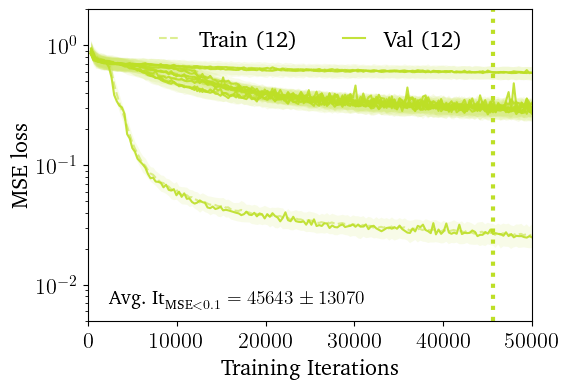

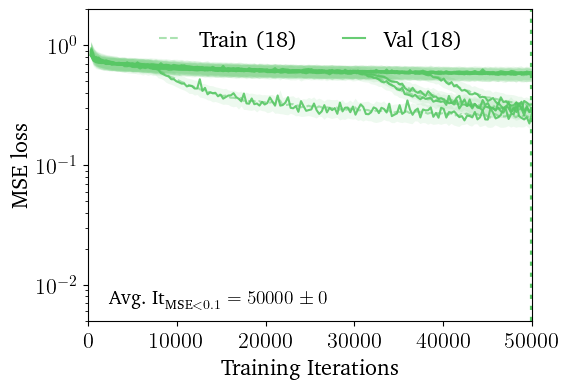

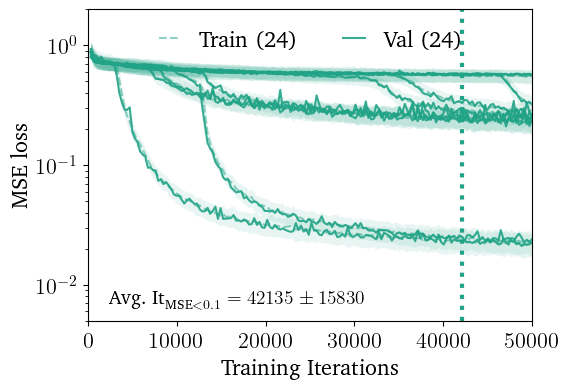

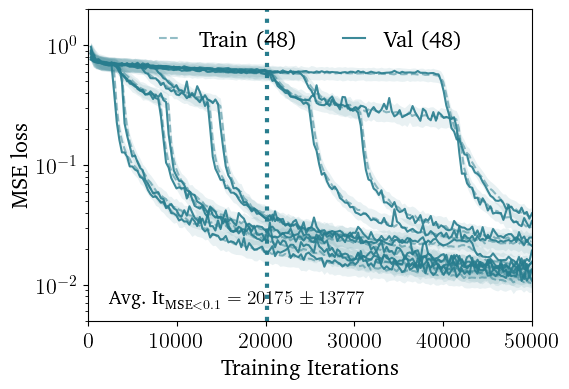

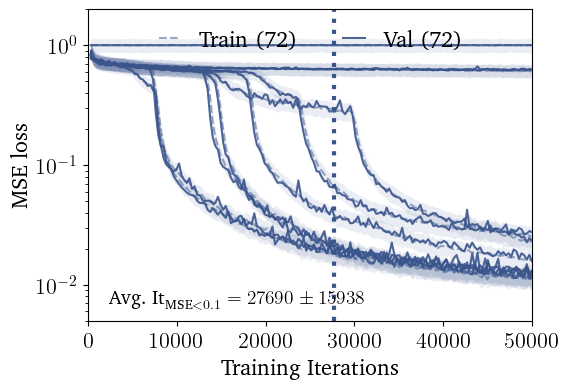

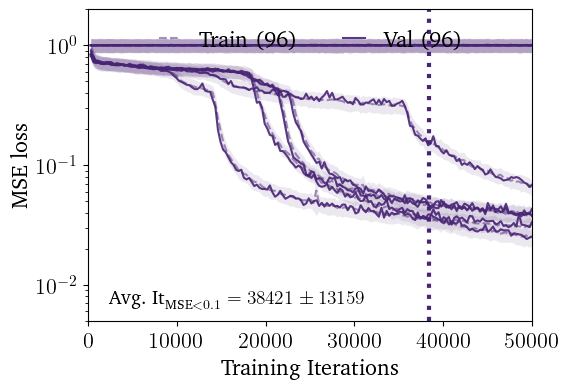

In [7]:
plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)
dims = [12, 18, 24, 48, 72, 96]
import matplotlib.cm as cm

cmap = cm.get_cmap("viridis")  # continuous

lo, hi = 0.1, 0.9  # pick your range
n_models = len(results)
positions = np.linspace(lo, hi, n_models)
train_cols = [cmap(p) for p in reversed(positions)]
# train_cols = [f"C{i}"                     for i in range(n_models)]
# val_cols   = [f"C{i + 2 + 2*n_models}"    for i in range(n_models)]
val_cols = train_cols.copy()
with PdfPages("figs/new_dataset/grok-gg_4g-losses-all.pdf") as pp:
    for dim in dims:
        fig, ax = plt.subplots(figsize=figsize)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)

        for idx, (name, runs) in enumerate(results.items()):
            if name != f"emb_{dim}":
                continue
            train_c, val_c = train_cols[idx], val_cols[idx]
            emb_label = name.split("_")[1]

            max_len_val = len(runs[0]["val"])
            val_matrix = np.zeros((max_len_val, len(runs)))
            trn_matrix = np.zeros((len(runs[0]["trn"]), len(runs)))

            position_where_val_crosses_0p1 = np.zeros((len(runs)))
            for run_idx, run in enumerate(runs):
                trn = np.array(run["trn"])
                val = np.array(run["val"])

                N = len(trn)
                M = len(val)
                factor = N // M
                avg_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].mean() for i in range(M)]
                )
                std_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].std() for i in range(M)]
                )
                x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

                ax.plot(
                    x_avg_trn,
                    avg_trn,
                    color=train_c,
                    linestyle="dashed",
                    alpha=0.5,
                    label=f"Train ({emb_label})" if run_idx == 0 else "",
                )
                # Plot std fill
                ax.fill_between(
                    x_avg_trn,
                    avg_trn - std_trn,
                    avg_trn + std_trn,
                    color=train_c,
                    alpha=0.1,
                    linewidth=0,
                    rasterized=True,  # helps keep PDF small
                )

                # x_trn = np.arange(1, len(trn) + 1)
                # # ax.plot(
                # #     x_trn, trn,
                # #     color=train_c, linestyle="solid", alpha=0.2,
                # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
                # # )

                scale = len(trn) / len(val)  # handles early‑stop curves
                x_val = np.arange(1, len(val) + 1) * scale
                ax.plot(
                    x_val,
                    val,
                    # marker="o", markersize=3, markeredgewidth=0.6,
                    color=val_c,
                    linestyle="solid",
                    alpha=0.9,
                    label=f"Val ({emb_label})" if run_idx == 0 else "",
                )

                # store for mean curve
                # val_matrix[:len(val), run_idx] = val
                trn_matrix[: len(trn), run_idx] = trn
                position_where_val_crosses_0p1[run_idx] = (
                    x_val[val < 0.1].min() if np.any(val < 0.1) else 50_000
                )
                # break
            # mean_val = np.mean(val_matrix, axis=1)
            # ax.plot(
            #     x_val, mean_val,
            #     color=val_c, linestyle="solid",
            #     label=f"Avg. Val. ({emb_label})"
            # )
            # mean_trn = np.mean(trn_matrix, axis=1)
            # ax.plot(
            #     x_trn, mean_trn,
            #     color=train_c, linestyle="solid",
            #     label=f"Avg. Trn. ({emb_label})",
            #     alpha=0.2,
            # )
            if not np.all(np.isnan(position_where_val_crosses_0p1)):
                # ax.axhline(
                #     0.1, color="black", linestyle="dashed", alpha=0.1,
                # )
                # for pos in position_where_val_crosses_0p1:
                #     if not np.isnan(pos):
                #         ax.axvline(
                #             pos, color=val_c, linestyle="dotted", alpha=0.5,
                #         )
                ax.axvline(
                    np.nanmean(position_where_val_crosses_0p1),
                    color=val_c,
                    linestyle="dotted",
                    alpha=1.0,
                    linewidth=3,
                )

                ax.text(
                    2275,
                    0.0075,
                    rf"$\text{{Avg. It}}_{{\text{{MSE}}<0.1}} = {np.nanmean(position_where_val_crosses_0p1):.0f}\pm {np.nanstd(position_where_val_crosses_0p1):.0f}$",
                    color="black",
                    fontsize=14,
                    ha="left",
                    va="center",
                    rotation=0,
                    alpha=1.0,
                )

                # ax.fill_between(
                #     [position_where_val_crosses_0p1.mean() - position_where_val_crosses_0p1.std(),
                #         position_where_val_crosses_0p1.mean() + position_where_val_crosses_0p1.std()],
                #     0, 100,
                #     color=val_c, alpha=0.1,
                # )

        # ------------------------------------------------------------------
        # y‑axis scale: purely log if all training losses > 0, otherwise symlog
        # (same criterion as original—last loop’s 'run' is still in scope)
        # ------------------------------------------------------------------
        ax.set_yscale("log" if np.all(np.array(run["trn"]) > 0) else "symlog")

        # ------------------------------------------------------------------
        ax.set_ylim(0.005, 2)
        ax.set_xlim(0, 50000)
        ax.set_xlabel("Training Iterations")
        ax.set_ylabel("MSE loss")
        ax.xaxis.get_major_formatter().set_useOffset(False)
        ax.xaxis.get_major_formatter().set_scientific(False)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, labels, frameon=False, loc="upper center", ncol=2, handlelength=1.0
        )
        fig.savefig(pp, format="pdf")

### Different iterations

Numpy predictions and targets were deleted for this file...

In [9]:
# path = "../../results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3/model"
# it_20217 = np.load(
#     os.path.join(path, "preds_vs_targets_20217.npy"), allow_pickle=True
# ).item()
# it_30179 = np.load(
#     os.path.join(path, "preds_vs_targets_30179.npy"), allow_pickle=True
# ).item()
# it_38383 = np.load(
#     os.path.join(path, "preds_vs_targets_38383.npy"), allow_pickle=True
# ).item()
# it_34867 = np.load(
#     os.path.join(path, "preds_vs_targets_34867.npy"), allow_pickle=True
# ).item()
# it_40434 = np.load(
#     os.path.join(path, "preds_vs_targets_40434.npy"), allow_pickle=True
# ).item()
# it_49810 = np.load(
#     os.path.join(path, "preds_vs_targets_49810.npy"), allow_pickle=True
# ).item()
# it_50000 = np.load(
#     os.path.join(path, "preds_vs_targets_50000.npy"), allow_pickle=True
# ).item()
# losses = load(path, "final")


# iterations_checks = [20217, 34867, 40434, 49810]
# colors = [f"C{i}" for i in range(len(iterations_checks))]
# with PdfPages("figs/new_dataset/grok/its_comparison.pdf") as pp:
#     fig, ax = plt.subplots(figsize=figsize)
#     fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
#     trn = np.array(losses["trn"])
#     val = np.array(losses["val"])

#     N = len(trn)
#     M = len(val)
#     factor = N // M
#     avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
#     std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
#     x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

#     ax.plot(
#         x_avg_trn,
#         avg_trn,
#         color="black",
#         linestyle="dashed",
#         alpha=0.5,
#         label=f"Trn (48)",
#     )
#     # Plot std fill
#     ax.fill_between(
#         x_avg_trn,
#         avg_trn - std_trn,
#         avg_trn + std_trn,
#         color="black",
#         alpha=0.1,
#         linewidth=0,
#         rasterized=True,  # helps keep PDF small
#     )

#     # x_trn = np.arange(1, len(trn) + 1)
#     # # ax.plot(
#     # #     x_trn, trn,
#     # #     color=train_c, linestyle="solid", alpha=0.2,
#     # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
#     # # )

#     scale = len(trn) / len(val)  # handles early‑stop curves
#     x_val = np.arange(1, len(val) + 1) * scale
#     ax.plot(
#         x_val,
#         val,
#         # marker="o", markersize=3, markeredgewidth=0.6,
#         color="black",
#         linestyle="solid",
#         alpha=0.9,
#         label=f"Val (48)",
#     )
#     for i, c in enumerate(colors):
#         ax.axvline(
#             iterations_checks[i],
#             color=c,
#             linestyle="dotted",
#             alpha=1.0,
#             linewidth=3,
#             label=f"It. {iterations_checks[i]}",
#         )
#     ax.set_yscale("linear")
#     ax.set_ylim(0.000, 0.9)
#     ax.set_xlim(0, 50000)
#     ax.set_xlabel("Training Iterations")
#     ax.set_ylabel("MSE loss")
#     ax.xaxis.get_major_formatter().set_useOffset(False)
#     ax.xaxis.get_major_formatter().set_scientific(False)

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, frameon=False, loc="lower left")
#     fig.subplots_adjust(left=rect[0], bottom=rect[1], right=rect[2], top=rect[3])
#     fig.savefig(pp, format="pdf")

#     truth = it_20217["targets"]
#     preds_20217 = it_20217["preds"]
#     preds_30179 = it_30179["preds"]
#     preds_34867 = it_34867["preds"]
#     preds_40434 = it_40434["preds"]
#     preds_49810 = it_49810["preds"]
#     preds_50000 = it_50000["preds"]

#     # undo standardization
#     for (truths, preds) in zip(
#         [
#             truth,
#             it_30179["targets"],
#             it_34867["targets"],
#             it_40434["targets"],
#             it_49810["targets"],
#             it_50000["targets"],
#         ],
#         [preds_20217, preds_30179, preds_34867, preds_40434, preds_49810, preds_50000],
#     ):
#         truths[:] = truths * (0.0097 + 1e-15) + 0.8925
#         preds[:] = preds * (0.0097 + 1e-15) + 0.8925

#     # plot the predictions
#     bins = np.linspace(0.85, 1.05, 64)

#     y_truth, y_err = compute_hist_data(bins, truth, bayesian=False)
#     y_preds_20217, y_err_20217 = compute_hist_data(bins, preds_20217, bayesian=False)
#     # y_preds_30179, y_err_30179 = compute_hist_data(
#     # bins, preds_30179, bayesian=False
#     # )
#     y_preds_34867, y_err_34867 = compute_hist_data(bins, preds_34867, bayesian=False)
#     y_preds_40434, y_err_40434 = compute_hist_data(bins, preds_40434, bayesian=False)
#     y_preds_49810, y_err_49810 = compute_hist_data(bins, preds_49810, bayesian=False)
#     # y_preds_50000, y_err_50000 = compute_hist_data(
#     # bins, preds_50000, bayesian=False
#     # )
#     lines = [
#         Line(
#             y=y_truth,
#             y_err=y_err,
#             label="Truth",
#             color=TRUTH_COLOR,
#         )
#     ]
#     for c, (y_preds, y_err_preds, it) in enumerate(
#         zip(
#             [y_preds_20217, y_preds_34867, y_preds_40434, y_preds_49810],
#             [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
#             iterations_checks,
#         )
#     ):
#         lines.append(
#             Line(
#                 y=y_preds,
#                 y_err=y_err_preds,
#                 y_ref=y_truth,
#                 label=f"Preds. It. {it}",
#                 color=colors[c],
#                 alpha=0.5,
#             )
#         )

#     hist_weights_plot(
#         pp,
#         lines,
#         bins,
#         show_ratios=False,
#         xlabel=r"$r(x)$",
#         xscale="linear",
#         title=r"$gg\to 4g$",
#         no_scale=True,
#         rect=rect,
#     )

#     # plot the truth/pred
#     bins = np.linspace(0.9, 1.1, 64)

#     y_ratios_20217, y_err_20217 = compute_hist_data(
#         bins, it_20217["targets"] / preds_20217, bayesian=False
#     )
#     # y_ratios_30179, y_err_30179 = compute_hist_data(
#     #     bins, it_30179["targets"] / preds_20217, bayesian=False
#     # )
#     y_ratios_34867, y_err_34867 = compute_hist_data(
#         bins, it_34867["targets"] / preds_34867, bayesian=False
#     )
#     y_ratios_40434, y_err_40434 = compute_hist_data(
#         bins, it_40434["targets"] / preds_40434, bayesian=False
#     )
#     y_ratios_49810, y_err_49810 = compute_hist_data(
#         bins, it_49810["targets"] / preds_49810, bayesian=False
#     )
#     # y_ratios_50000, y_err_50000 = compute_hist_data(
#     #     bins, it_50000["targets"] / preds_50000, bayesian=False
#     # )
#     lines = []
#     for c, (y_ratios, y_err_ratios, it) in enumerate(
#         zip(
#             [y_ratios_20217, y_ratios_34867, y_ratios_40434, y_ratios_49810],
#             [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
#             iterations_checks,
#         )
#     ):
#         lines.append(
#             Line(
#                 y=y_ratios,
#                 y_err=y_err_ratios,
#                 y_ref=None,
#                 label=f"It. {it}",
#                 color=colors[c],
#                 alpha=0.5,
#             )
#         )

#     hist_weights_plot(
#         pp,
#         lines,
#         bins,
#         show_ratios=False,
#         xlabel=r"$r^{\text{true}}/r^{\text{pred}}$",
#         xscale="linear",
#         title=r"$gg\to 4g$",
#         no_scale=True,
#         rect=rect,
#     )

#     # plot deltas
#     bins = np.linspace(-0.1, 0.1, 64)

#     y_deltas_20217, y_err_20217 = compute_hist_data(
#         bins, (preds_20217 - it_20217["targets"]) / it_20217["targets"], bayesian=False
#     )
#     # y_deltas_30179, y_err_30179 = compute_hist_data(
#     #     bins, (preds_30179 - it_30179["targets"]) / it_30179["targets"], bayesian=False
#     # )
#     y_deltas_34867, y_err_34867 = compute_hist_data(
#         bins, (preds_34867 - it_34867["targets"]) / it_34867["targets"], bayesian=False
#     )
#     y_deltas_40434, y_err_40434 = compute_hist_data(
#         bins, (preds_40434 - it_40434["targets"]) / it_40434["targets"], bayesian=False
#     )
#     y_deltas_49810, y_err_49810 = compute_hist_data(
#         bins, (preds_49810 - it_49810["targets"]) / it_49810["targets"], bayesian=False
#     )
#     # y_deltas_50000, y_err_50000 = compute_hist_data(
#     #     bins, (preds_50000 - it_50000["targets"]) / it_50000["targets"], bayesian=False
#     # )
#     lines = []
#     for c, (y_deltas, y_err_deltas, it) in enumerate(
#         zip(
#             [y_deltas_20217, y_deltas_34867, y_deltas_40434, y_deltas_49810],
#             [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
#             iterations_checks,
#         )
#     ):
#         lines.append(
#             Line(
#                 y=y_deltas,
#                 y_err=y_err_deltas,
#                 y_ref=None,
#                 label=f"It. {it}",
#                 color=colors[c],
#                 alpha=0.5,
#             )
#         )

#     hist_weights_plot(
#         pp,
#         lines,
#         bins,
#         show_ratios=False,
#         xlabel=r"$\Delta_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
#         xscale="linear",
#         title=r"$gg\to 4g$",
#         no_scale=True,
#         rect=rect,
#     )

#     # plot abs deltas
#     bins = np.logspace(-10, -0.5, 64)

#     y_absdeltas_20217, y_err_20217 = compute_hist_data(
#         bins,
#         np.abs(preds_20217 - it_20217["targets"]) / it_20217["targets"],
#         bayesian=False,
#     )
#     # y_absdeltas_30179, y_err_30179 = compute_hist_data(
#     #     bins, np.abs(preds_30179 - it_30179["targets"]) / it_30179["targets"], bayesian=False
#     # )
#     y_absdeltas_34867, y_err_34867 = compute_hist_data(
#         bins,
#         np.abs(preds_34867 - it_34867["targets"]) / it_34867["targets"],
#         bayesian=False,
#     )
#     y_absdeltas_40434, y_err_40434 = compute_hist_data(
#         bins,
#         np.abs(preds_40434 - it_40434["targets"]) / it_40434["targets"],
#         bayesian=False,
#     )
#     y_absdeltas_49810, y_err_49810 = compute_hist_data(
#         bins,
#         np.abs(preds_49810 - it_49810["targets"]) / it_49810["targets"],
#         bayesian=False,
#     )
#     # y_absdeltas_50000, y_err_50000 = compute_hist_data(
#     #     bins, np.abs(preds_50000 - it_50000["targets"]) / it_50000["targets"], bayesian=False
#     # )
#     lines = []
#     for c, (y_absdeltas, y_err_deltas, it) in enumerate(
#         zip(
#             [y_absdeltas_20217, y_absdeltas_34867, y_absdeltas_40434, y_absdeltas_49810],
#             [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
#             iterations_checks,
#         )
#     ):
#         lines.append(
#             Line(
#                 y=y_absdeltas,
#                 y_err=y_err_deltas,
#                 y_ref=None,
#                 label=f"It. {it}",
#                 color=colors[c],
#                 alpha=0.5,
#             )
#         )

#     hist_weights_plot(
#         pp,
#         lines,
#         bins,
#         show_ratios=False,
#         xlabel=r"$|\Delta_{r}|$",
#         xscale="log",
#         title=r"$gg\to 4g$",
#         no_scale=True,
#         rect=rect,
#         legend_kwargs={
#             "loc": "center left",
#         },
#     )

### Test of symmetries

In [10]:
COLOR_BOOST = "firebrick"
COLOR_SO3 = "hotpink"
COLOR_SL4 = "#9370DB"
COLOR_SHEAR = "darkorange"
COLOR_SO2 = "#1E90FF"
# get all filenames in results/Transformer/Grokking-bigger_shear
SymmetriesTest_files = [
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_195722-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_195732-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_195803-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_195817-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_195820-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0802_195846-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_200003-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_224552-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-19",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_234242-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_234250-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_140441-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_140627-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_140627-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19",
    "results/Transformer/Grokking-bigger_shear/0803_163529-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_163606-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0803_163606-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0803_163645-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0803_163723-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0803_163741-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0803_163752-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0803_163805-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0803_163821-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0803_163842-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0803_163912-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0803_164340-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0803_164416-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0803_164510-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0804_154603-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0804_154825-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0804_155227-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0804_155301-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0804_161923-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0804_165315-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0804_165945-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0804_170015-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0804_201309-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0804_212408-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0804_223152-GrokkingExp-SymmetriesTest-bigger_shear-123",
    "results/Transformer/Grokking-bigger_shear/0804_223530-GrokkingExp-SymmetriesTest-bigger_shear-124",
    "results/Transformer/Grokking-bigger_shear/0804_223822-GrokkingExp-SymmetriesTest-bigger_shear-125",
    "results/Transformer/Grokking-bigger_shear/0804_231259-GrokkingExp-SymmetriesTest-bigger_shear-126",
    "results/Transformer/Grokking-bigger_shear/0804_231520-GrokkingExp-SymmetriesTest-bigger_shear-127",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0807_162949-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0807_162949-GrokkingExp-SymmetriesTest-bigger_shear-1",
]
print(f"Found {len(SymmetriesTest_files)} symmetry test files.")


def read_symmetry_file(filename):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    metrics = {
        "mu": "mu_deltas_{}_abs",
        "median": "median_deltas_{}_abs",
        "sigma": "std_deltas_{}_abs",
        "loss_median": "loss_{}_median",
        "loss_mean": "loss_{}_mean",
    }
    data = {}

    with open(filename, "r") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(",")
            entry = {}
            iter_num = None
            for p in parts:
                key, val = p.strip().split(":", 1)
                key = key.strip()
                val = float(val.strip())
                if key == "iteration":
                    iter_num = int(val)
                    entry = {}
                else:
                    entry[key] = val

            # Structure the entry by symmetry and metrics
            out = {}
            for sym in symmetry_types:
                out[sym] = {
                    "mu": entry.get(f"mu_deltas_{sym}_abs"),
                    "median": entry.get(f"median_deltas_{sym}_abs"),
                    "sigma": entry.get(f"std_deltas_{sym}_abs"),
                    "loss_median": entry.get(f"loss_{sym}_median")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_median"),
                    "loss_mean": entry.get(f"loss_{sym}_mean")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_mean"),
                }
                out["mse_loss_median"] = entry.get("loss_median", None)
            data[iter_num] = out
    return data


def extract_mus(data):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    x = sorted(data.keys())
    mu = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    median = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    sigma = {sym: data[it][sym]["sigma"] for it in x for sym in symmetry_types}
    sym_loss_median = {
        sym: [data[it][sym]["loss_median"] for it in x] for sym in symmetry_types
    }
    sym_loss_mean = {
        sym: [data[it][sym]["loss_mean"] for it in x] for sym in symmetry_types
    }
    mse_loss_median = [
        data[it]["mse_loss_median"] for it in x if "mse_loss_median" in data[it]
    ]
    return x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median

Found 120 symmetry test files.


In [11]:
example1_overleaf = "0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-0", 0
example2_overleaf = "0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-2", 2

In [12]:
symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]


x_ref = np.zeros((len(SymmetriesTest_files), 171))
mu_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sigma_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
sym_loss_median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sym_loss_mean_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
mse_loss_median_matrix = np.zeros((len(SymmetriesTest_files), 171))

mse_loss_mean_matrix = np.zeros((len(SymmetriesTest_files), 171))

for i, f in enumerate(SymmetriesTest_files):
    logfile = os.path.join("../../", f, "grokking.log")
    result = read_symmetry_file(logfile)
    x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median = extract_mus(
        result
    )
    x_ref[i, :] = x  # store the x values for reference
    for sym in symmetry_types:
        mu_matrix[sym][i, :] = mu[sym]
        median_matrix[sym][i, :] = median[sym]
        sigma_matrix[sym][i, :] = sigma[sym]
        sym_loss_median_matrix[sym][i, :] = sym_loss_median[sym]
        sym_loss_mean_matrix[sym][i, :] = sym_loss_mean[sym]

        mse_loss_median_matrix[i, :] = mse_loss_median
    mse_loss_mean = load(os.path.join("../../", f, "model"), "final")["val"]
    mse_loss_mean_matrix[i, :] = mse_loss_mean  # store the losses for this file

In [13]:
def moving_average(arr, window=10):
    """Simple moving average with reflection at edges."""
    return np.convolve(arr, np.ones(window) / window, mode="same")


window = 1  # or any window size you prefer

mask = np.ones_like(x_ref[0], dtype=bool)
# mask = x_ref[0] > 10000

In [14]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}


with PdfPages("figs/new_dataset/grok/delta_median-vs-MSE_median.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        axright = ax.twinx()
        axright.set_yscale("log")
        axright.set_ylabel(r"Med(MSE loss)", color="forestgreen")
        axright.spines["right"].set_color("forestgreen")
        axright.yaxis.label.set_color("forestgreen")
        axright.tick_params(axis="y", colors="forestgreen")
        axright.yaxis.set_minor_locator(ticker.LogLocator(subs="auto", numticks=10))
        axright.tick_params(axis="y", which="minor", colors="forestgreen")
        axright.yaxis.set_minor_formatter(
            ticker.NullFormatter()
        )  # Hide minor tick labels if desired

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = median_matrix["SO2"][i][mask]
        median_boost = median_matrix["boost"][i][mask]
        median_SO3 = median_matrix["SO3"][i][mask]
        median_SL4 = median_matrix["SL4"][i][mask]
        median_shear = median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        axright.plot(
            x,
            ma_mse_loss_median,
            label=None,
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_median_SO3 = moving_average(median_SO3, window)
        ax.plot(
            x,
            ma_median_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(0.005, 50)
        ax.set_xlim(0, 50000)
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = axright.get_legend_handles_labels()

        # Combine
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax.legend(handles, labels, frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(
            left=rect_both_axes[0],
            bottom=rect_both_axes[1],
            right=rect_both_axes[2],
            top=rect_both_axes[3],
        )
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE loss})$")
        # ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(0.005, 50)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        corr = np.corrcoef(y, median_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, median_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, median_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, median_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, median_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]

        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [15]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}
corr_under0p002 = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_over0p002 = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}

with PdfPages("figs/new_dataset/grok/sym_loss_median-vs-MSE_median.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = sym_loss_median_matrix["SO2"][i][mask]
        median_boost = sym_loss_median_matrix["boost"][i][mask]
        median_SO3 = sym_loss_median_matrix["SO3"][i][mask]
        median_SL4 = sym_loss_median_matrix["SL4"][i][mask]
        median_shear = sym_loss_median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        ax.plot(
            x,
            ma_mse_loss_median,
            label="No tfm.",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_median_SO3 = moving_average(median_SO3, window)
        ax.plot(
            x,
            ma_median_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(2e-5, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(2e-5, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        x_below_0p001 = np.where(y < 1e-3)[0][0]
        for (sym, m) in zip(
            ["SO2", "boost", "SO3", "SL4", "shear"],
            [median_SO2, median_boost, median_SO3, median_SL4, median_shear],
        ):
            corr = np.corrcoef(y, m)[0, 1]
            corr_matrix[sym][i] = corr

            corr_under0p002[sym][i] = np.corrcoef(y[y < 0.002], m[y < 0.002])[0, 1]
            corr_over0p002[sym][i] = np.corrcoef(y[y >= 0.002], m[y >= 0.002])[0, 1]

    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):
        if sym == "SO2":
            bins = np.linspace(0.9995, 1.00005, 32)
        else:
            bins = np.linspace(-1.2, 1.2, 32)

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$" if sym != 'SO2' else rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2e} \pm {np.std(corr_matrix[sym]):.2e}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

        y_under0p002, y_err_under0p002 = compute_hist_data(
            bins, corr_under0p002[sym], bayesian=False
        )
        y_over0p002, y_err_over0p002 = compute_hist_data(
            bins, corr_over0p002[sym], bayesian=False
        )
        lines = [
            Line(
                y=y_over0p002,
                y_err=None,
                label=f"{sym_label} ($\\text{{MSE}}^{{0}} \geq 0.002$)",
                color="blue",
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.nanmean(corr_over0p002[sym]),
                y_err=np.nanstd(corr_over0p002[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym][mse_loss_median_matrix[i, :] >= 0.1]):.2f} \pm {np.std(corr_matrix[sym][mse_loss_median_matrix[i, :] >= 0.1]):.2f}$",
                color="blue",
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
            Line(
                y=y_under0p002,
                y_err=None,
                label=f"{sym_label} ($\\text{{MSE}}^{{0}} < 0.002$)",
                color="red",
                alpha=1.0,
                linestyle="dashed",
                linewidth=2,
            ),
            Line(
                y=np.nanmean(corr_under0p002[sym]),
                y_err=np.nanstd(corr_under0p002[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X, \mathbf{{Y}}}}}}} = {np.mean(corr_matrix[sym][mse_loss_median_matrix[i, :] < 0.1]):.2f} \pm {np.std(corr_matrix[sym][mse_loss_median_matrix[i, :] < 0.1]):.2f}$",
                color="red",
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [16]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}


with PdfPages("figs/new_dataset/grok/sym_loss_mean-vs-MSE_mean.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mean_SO2 = sym_loss_mean_matrix["SO2"][i][mask]
        mean_boost = sym_loss_mean_matrix["boost"][i][mask]
        mean_SO3 = sym_loss_mean_matrix["SO3"][i][mask]
        mean_SL4 = sym_loss_mean_matrix["SL4"][i][mask]
        mean_shear = sym_loss_mean_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ax.plot(
            x,
            ma_mse_loss_mean,
            label="No tfm.",
            linestyle="dotted",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )
        # ax.plot(x, ma_mse_loss_mean, label='No tfm.', color = 'forestgreen', linewidth=2, alpha = 0.75)

        # SO(2)
        ma_mean_SO2 = moving_average(mean_SO2, window)
        ax.plot(
            x,
            ma_mean_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_mean_boost = moving_average(mean_boost, window)
        ax.plot(
            x,
            ma_mean_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_mean_SO3 = moving_average(mean_SO3, window)
        ax.plot(
            x,
            ma_mean_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_mean_SL4 = moving_average(mean_SL4, window)
        ax.plot(
            x,
            ma_mean_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_mean_shear = moving_average(mean_shear, window)
        ax.plot(
            x,
            ma_mean_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(5e-3, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Mean}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(5e-3, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_mean

        corr = np.corrcoef(y, mean_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, mean_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, mean_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, mean_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, mean_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):
        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

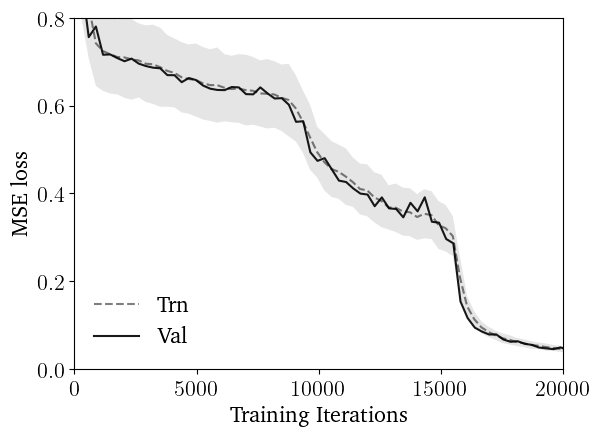

In [17]:
## Losses plot for overleaf :)
path = f"../../results/Transformer/Grokking-bigger_shear/{example1_overleaf[0]}/model"
losses = load(path, "final")
with PdfPages(f"figs/new_dataset/grok/loss_plot-{example1_overleaf[0]}.pdf") as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
    std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn,
        avg_trn,
        color="black",
        linestyle="dashed",
        alpha=0.5,
        label=f"Trn",
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True,  # helps keep PDF small
    )

    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)  # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val,
        val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black",
        linestyle="solid",
        alpha=0.9,
        label=f"Val",
    )

    ax.set_yscale("linear")
    ax.set_ylim(0, 0.8)
    ax.set_xlim(0, 20000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    # ax.xaxis.get_major_formatter().set_useOffset(False)
    # ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
    fig.savefig(pp, format="pdf")